In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

df_odin = pd.read_csv('enquiries_odin.csv')
df_loki =  pd.read_csv('enquiries_loki.csv')

# drop rows where contains any elements are nan
df_odin = df_odin.dropna(axis=0, how='any')
df_loki = df_loki.dropna(axis=0, how='any')

df_enquiries = pd.merge(df_odin, df_loki, on=['Fleats Id'])
# remove undefined
df_enquiries = df_enquiries[~df_enquiries['Applicant 1 Annual Salary'].isin(['undefined'])]
df_enquiries = df_enquiries.drop('Fleats Id', 1)

# X = df_enquiries[['Marketing Code', 'Classification', 'Loan Amount']]
X = df_enquiries.loc[:, df_enquiries.columns != 'Enquiry Status']
y = df_enquiries['Enquiry Status']

In [2]:
print("Keys of enquiries_dataset: \n{}".format(X.keys()))

Keys of enquiries_dataset: 
Index(['Marketing Code', 'Classification', 'Loan Amount', 'Client Name',
       'Suburb', 'State', 'Post Code', 'loan_reason', 'property_use', 'Price',
       'Purchase Timeframe', 'Existing Properties', 'Employment Status',
       'Applicant 1 Annual Salary', 'Applicant 1 Available Funds',
       'Applicant 2 Monthly Credit Card Limit',
       'Applicant 2 Monthly Loan Repayments', 'Applicant 2 Employment Status',
       'Applicant 2 Annual Salary', 'Applicant 2 Available Funds'],
      dtype='object')


In [3]:
print("Shape of X: {}".format(X.shape))
print("Shape of y: {}".format(y.shape))

Shape of X: (1026, 20)
Shape of y: (1026,)


In [4]:
from sklearn.preprocessing import LabelEncoder

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
# Categorial feature ecoding
X = MultiColumnLabelEncoder(columns = X.keys()).fit_transform(X)
y = le.fit_transform(y)

In [6]:
# feature selection
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)

# Get idxs of columns to keep
idxs_selected = model.get_support(indices=True)

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# split data and labels into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(X_new, y, random_state=0)
# rescale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [8]:
from sklearn.neighbors import KNeighborsClassifier

kn = KNeighborsClassifier(n_neighbors=3)
kn.fit(X_train_scaled, y_train)
pred_kn = kn.predict(X_test)
print("Test score: {:.2f}".format(kn.score(X_test_scaled, y_test)))

Test score: 0.70


In [9]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(loss="hinge", penalty="l2")
sgd.fit(X_train_scaled, y_train)
pred_sgd = sgd.predict(X_test)
print("Test score: {:.2f}".format(sgd.score(X_test_scaled, y_test)))

Test score: 0.73


/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [10]:
from sklearn.kernel_approximation import RBFSampler

rbf_feature = RBFSampler(gamma=1, random_state=1)
X_features = rbf_feature.fit_transform(X_train_scaled)
clf = SGDClassifier()  
clf.fit(X_train_scaled, y_train)
print("Test score: {:.2f}".format(clf.score(X_test_scaled, y_test)))

Test score: 0.69


/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [11]:
from sklearn import svm
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import cross_val_score

svc = svm.SVC()
svc.fit(X_train, y_train)
pred_svc = svc.predict(X_test)
print("Test score: {:.2f}".format(svc.score(X_test, y_test)))

# scores = cross_val_score(clf, X, y, cv=5)
# scores
# N = range(1, 16)
# for n in N:
#     pca = KernelPCA(n_components=n)
#     X_n_kept = pca.fit_transform(X_test_scaled)
#     # Estimate accuracy on the data set with top n components
#     classifier = svm.SVC(gamma=0.001)
#     score_n_components = cross_val_score(classifier, X_n_kept, y_test).mean()
#     print('Score with the data set of top {0} components: {1:.2f}'.format(n, score_n_components))

Test score: 0.79


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics

rfc = RandomForestClassifier(n_estimators=500)
rfc.fit(X_train_scaled, y_train)
pred_forest = rfc.predict(X_test)

print("Test score: {:.2f}".format(rfc.score(X_test_scaled, y_test)))

scores = cross_val_score(rfc, X_test_scaled, y_test)
print("Cross-validation scores: {}".format(scores.mean()))


# N = range(1, 100)
# best_score = 0
# n_estimators = 1
# for n in N:
#     rfc = RandomForestClassifier(n_estimators=n, n_jobs=-1)
#     rfc.fit(X_train_scaled, y_train)
#     score_n_components = cross_val_score(clf, X_test_scaled, y_test).mean()
#     if(best_score < score_n_components):
#         best_score = score_n_components
#         n_estimators = n
#     print('Score with the data set of top {0} components: {1:.2f}'.format(n, score_n_components))
# print('best socre is: {1:.2f} with {0} estimators'.format(best_score,n_estimators))

Test score: 0.82
Cross-validation scores: 0.789975305813317


 1) Client Name                    0.181193
 2) Suburb                         0.095632
 3) State                          0.091955
 4) Loan Amount                    0.089170
 5) Price                          0.083049
 6) loan_reason                    0.081487
 7) Applicant 1 Annual Salary      0.076969
 8) Marketing Code                 0.055406
 9) Post Code                      0.047737
10) Purchase Timeframe             0.045974
11) Existing Properties            0.039811
12) Applicant 1 Available Funds    0.035445
13) Classification                 0.029866
14) Employment Status              0.026104
15) property_use                   0.020202


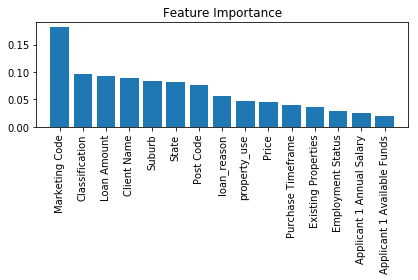

In [13]:
feat_labels = X.columns[0:]
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,feat_labels[indices[f]],importances[indices[f]]))
    
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]),importances[indices],align='center')
plt.xticks(range(X_train.shape[1]),feat_labels, rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [14]:
from sklearn.metrics import confusion_matrix

print("KNeighborsClassifier:")
print(confusion_matrix(y_test, pred_kn))
print("\nSGDClassifier:")
print(confusion_matrix(y_test, pred_sgd))
print("\nSVC:")
print(confusion_matrix(y_test, pred_svc))
print("\nRandomForestClassifier")
print(confusion_matrix(y_test, pred_forest))

KNeighborsClassifier:
[[  0   0  29]
 [  0   0  25]
 [  7   4 192]]

SGDClassifier:
[[ 29   0   0]
 [ 25   0   0]
 [203   0   0]]

SVC:
[[  0   0  29]
 [  0   0  25]
 [  0   0 203]]

RandomForestClassifier
[[  0   0  29]
 [  0   0  25]
 [  0   0 203]]


In [15]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

print("f1 score KNeighborsClassifier: {:.2f}".format(f1_score(y_test, pred_kn, average='weighted')))
print("f1 score SGDClassifier: {:.2f}".format(f1_score(y_test, pred_sgd,average='weighted')))
print("f1 score SVC: {:.2f}".format(f1_score(y_test, pred_svc,average='weighted')))
print("f1 score RandomForestClassifier: {:.2f}".format(f1_score(y_test, pred_forest,average='weighted')))
print()
print("precision score KNeighborsClassifier: {:.2f}".format(precision_score(y_test, pred_kn, average='weighted')))
print("precision score SGDClassifier: {:.2f}".format(precision_score(y_test, pred_sgd,average='weighted')))
print("precision score SVC: {:.2f}".format(precision_score(y_test, pred_svc,average='weighted')))
print("precision score RandomForestClassifier: {:.2f}".format(precision_score(y_test, pred_forest,average='weighted')))

f1 score KNeighborsClassifier: 0.68
f1 score SGDClassifier: 0.02
f1 score SVC: 0.70
f1 score RandomForestClassifier: 0.70

precision score KNeighborsClassifier: 0.62
precision score SGDClassifier: 0.01
precision score SVC: 0.62
precision score RandomForestClassifier: 0.62


/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [16]:
input_x = df_enquiries.iloc[:]
input_x_test = df_enquiries.iloc[:,idxs_selected]
# input_x = input_x.iloc[0,idxs_selected]

# input_x = input_x.drop('Enquiry Status', 1)

input_x_test = MultiColumnLabelEncoder(columns = input_x_test.keys()).fit_transform(input_x_test)
input_x_test = scaler.fit_transform(input_x_test)

# for row in input_x:
#     result = rfc.predict(row)[0]
#     proba = np.max(rfc.predict_proba(row))    

#     print('reuslt: {}'.format(le.inverse_transform(result)))
#     print('probability: {0}%'.format(proba))
#     print()

# result = rfc.predict(input_x)[0]
# proba = np.max(rfc.predict_proba(input_x))    

# print('reuslt: {}'.format(le.inverse_transform(result)))
# print('probability: {0}%'.format(proba))
result = rfc.predict(input_x_test)
result = le.inverse_transform(result)
proba = rfc.predict_proba(input_x_test)   
proba = [np.max(p) for p in proba]
# input_x.to_csv('example.csv')

In [18]:
input_x = input_x.assign(predict=result.tolist())
input_x = input_x.assign(possibility=proba)
input_x.head()
input_x.to_csv('result/v1.csv')